In [1]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import  DataLoader
import torch
from Network import *
from torchvision.transforms import transforms
from PIL import Image
import pandas as pd
import random
from torch import optim
from torch.optim import lr_scheduler
import copy

In [2]:
root_dir = 'data/cats_and_dogs_small/'
train_dir = 'train/'
val_dir = 'val/'
test_dir = 'test/'
train_anno = 'anno/Classes_train_annotation.csv'
val_anno = 'anno/Classes_val_annotation.csv'
test_anno = 'anno/Classes_test_annotation.csv'
classes = ['cat', 'dog']

In [3]:
class myDataset():
    '''
    用于获取图片数据
    '''
    def __init__(self, root_dir, annotations_file, transform= None):
        self.rootdir = root_dir
        self.annotations_file = self.rootdir + annotations_file
        self.transform = transform
        
        if not os.path.isfile(self.annotations_file):
            print(self.annotations_file + 'does not exis!')
        
        self.file_info = pd.read_csv(self.annotations_file, index_col= None)
        self.size = len(self.file_info)
    
    def __call__(self):
        print('使用__getitem__(idx)获取图片数据')
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        '''
        定义了__getitem__魔法函数，该类就可以下标操作了：[]
        '''
        image_path = self.file_info['path'][idx]
        if not os.path.isfile(image_path):
            print(image_path + 'does not exis!')
            return None
        
        image = Image.open(image_path).convert('RGB')
        label_class = int(self.file_info['classes'][idx])
        sample = {'image': image, 'classes': label_class}
        
        if self.transform:
            sample['image'] = self.transform(image)
        
        return sample

In [4]:
def train_model(model, data_loaders, criterion, optimizer, scheduler, num_epochs= 50):
    '''
    model: 需要训练的网络
    criterion：评价标准
    optimizer：优化器
    scheduler：学习率衰减
    num_epochs：迭代次数
    '''
    loss_list_classes = {'train':[], 'val':[]}
    
    accuracy_list_classes = {'train':[], 'val':[]}
    
    #保存最好的模型与精度
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch + 1, num_epochs))
        print('-*' * 10)
        #每个epoch都需要进行一次训练与验证的过程
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            corrects_classes = 0
            
            for idx, data in enumerate(data_loaders[phase]):
                if phase == 'train':
                    print('training on batch {}'.format(idx))

                inputs = data['image'].to(device)
                labels_classes = data['classes'].to(device)
                #每个batch都需要重新计算梯度，所以清空
                optimizer.zero_grad()
                
                #只有在训练过程中需要反向传播，所以测试过程中可以set_grad_enabled(Flase)
                with torch.set_grad_enabled(phase == 'train'):
                    x_classes = model(inputs)
                    #得到的是classes的概率，需要继续转为类别
                    x_classes = x_classes.view(-1, 2)
                    #preds_classes对应第几列的索引，即0还是1
                    _, preds_classes = torch.max(x_classes, 1)
                    #这里的 nn.CrossEntropyLoss()中第二个参数可以理解是groundtruth中‘1’的位置
                    #加权损失函数
                    criterion.weight = torch.tensor(data = [1,1],dtype= torch.float)
                    loss = criterion(x_classes, labels_classes) #如果不需要的话,criterion.weight = None
                                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #loss.item() 返回一个value，乘以一个input.size，防止最后一组input数量不等
                running_loss += loss * inputs.size(0)
                #计算正确分类的个数
                corrects_classes += torch.sum(preds_classes == labels_classes)
                                
            #求整个batch的loss
            loss_list_classes[phase].append(running_loss / len(data_loaders[phase].dataset))
            
            epoch_acc_classes = corrects_classes.double() / len(data_loaders[phase].dataset)
            
            #乘以100应该是为了后面显示（）% ???
            accuracy_list_classes[phase].append(100 * epoch_acc_classes)
            #用测试集测试，记录最佳权值
            if phase == 'val' and epoch_acc_classes > best_acc:
                best_acc = epoch_acc_classes
                best_model_weights = copy.deepcopy(model.state_dict())
                print('Best val classes Acc: {:.2%}'.format(best_acc))
        
        #学习率衰减
        exp_lr_scheduler.step()
    
    #保存模型
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(),'model/Acc_{:04d}.pt'.format(round(best_acc.item() * 100)))
    print('Best val classes Acc: {:.2%}'.format(best_acc))
    return model, loss_list_classes, accuracy_list_classes

In [12]:
#transforms:按顺序进行相应transform操作
train_tranfroms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.RandomHorizontalFlip(p = 0.1),
                                      transforms.RandomApply([transforms.RandomRotation(5,Image.BILINEAR)],p= 0.1),
                                      transforms.ToTensor()
                                     ])
val_tranfroms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor()
                                   ])
test_tranfroms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor()
                                   ])
# 将数据路径实例化
train_dataset = myDataset(root_dir= root_dir, 
                          annotations_file= train_anno, 
                          transform = train_tranfroms
                         )
val_dataset = myDataset(root_dir= root_dir, 
                        annotations_file= val_anno, 
                        transform = val_tranfroms
                       )
test_dataset = myDataset(root_dir= root_dir, 
                        annotations_file= test_anno, 
                        transform = val_tranfroms
                       )

In [13]:
# 转化为Dataloader
train_loader = DataLoader(dataset= train_dataset, batch_size= 64, shuffle= True)
val_loader = DataLoader(dataset= val_dataset)
test_loader = DataLoader(dataset= test_dataset)
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [10]:
#选择gpu/cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#train,train,train,train,train
network = Net().to(device)
#冻结某些层
for param in network.parameters():
    param.requires_grad = False
for param in network.resnet18.fc.parameters():
    param.requires_grad = True
    
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
#每步衰减至0.95 * 上步学习率
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size= 1, gamma= 0.95)
#训练网络
num_epochs = 1
model, loss_list_classes, accuracy_list_classes = train_model(network, 
                                                  data_loaders, 
                                                  criterion, 
                                                  optimizer, 
                                                  exp_lr_scheduler, 
                                                  num_epochs= num_epochs)

cpu
Epoch1/1
-*-*-*-*-*-*-*-*-*-*
training on batch 0
training on batch 1
training on batch 2
training on batch 3
training on batch 4
training on batch 5
training on batch 6
training on batch 7
training on batch 8
training on batch 9
training on batch 10
training on batch 11
training on batch 12
training on batch 13
training on batch 14
training on batch 15
training on batch 16
training on batch 17
training on batch 18
training on batch 19
training on batch 20
training on batch 21
training on batch 22
training on batch 23
training on batch 24
training on batch 25
training on batch 26
training on batch 27
training on batch 28
training on batch 29
training on batch 30
training on batch 31
Best val classes Acc: 95.20%
Best val classes Acc: 95.20%


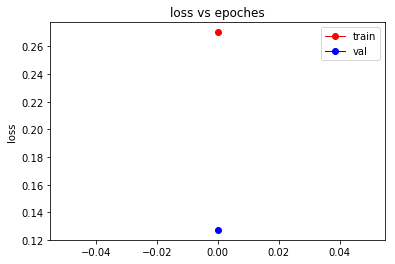

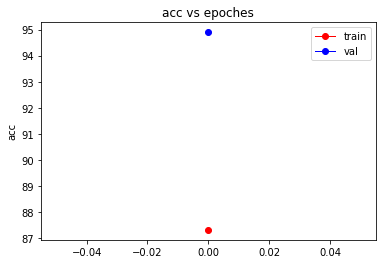

In [9]:
def visualize_loss_acc(loss, acc):
    x = range(0, num_epochs)
    y1 = loss['train']
    y2 = loss['val']
    plt.plot(x, y1, color="r", linestyle="-", marker="o", linewidth=1, label="train")
    plt.plot(x, y2, color="b", linestyle="-", marker="o", linewidth=1, label="val")
    plt.legend()
    plt.title('loss vs epoches')
    plt.ylabel('loss')
    plt.savefig('figure/loss vs epoches.jpg')
    plt.show()
    plt.close('all')
    
    y3 = acc['train']
    y4 = acc['val']
    plt.plot(x, y3, color="r", linestyle="-", marker="o", linewidth=1, label="train")
    plt.plot(x, y4, color="b", linestyle="-", marker="o", linewidth=1, label="val")
    plt.legend()
    plt.title('acc vs epoches')
    plt.ylabel('acc')
    plt.savefig('figure/acc vs epoches.jpg')
    plt.show()
    plt.close('all')

visualize_loss_acc(loss_list_classes, accuracy_list_classes)

torch.Size([1, 3, 224, 224])


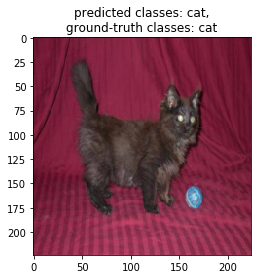

In [12]:
############################################ Visualization ###############################################
def visualize_model(model,idx):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loaders['test']):
            if i < idx:
                continue
            elif i > idx:
                break
            inputs = data['image']
            labels_classes = data['classes'].to(device)

            x_classes = model(inputs.to(device))
            x_classes = x_classes.view( -1,2)
            _, preds_classes = torch.max(x_classes, 1)
            print(inputs.shape)
            plt.imshow(transforms.ToPILImage()(inputs.squeeze(0)))
            plt.title('predicted classes: {},\nground-truth classes: {}'.format(classes[preds_classes], 
                                                                                classes[labels_classes], 
                                                                                )
                     )
            plt.show()

visualize_model(model,11)

32


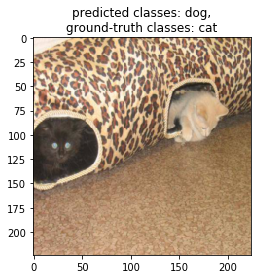

47


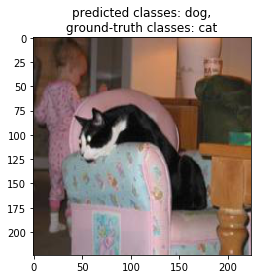

130


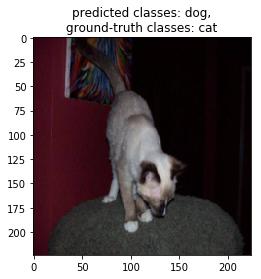

172


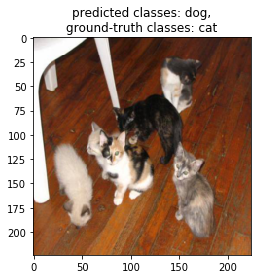

250


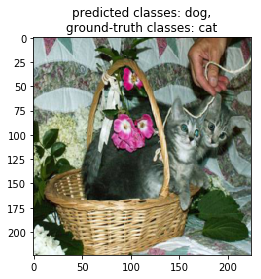

251


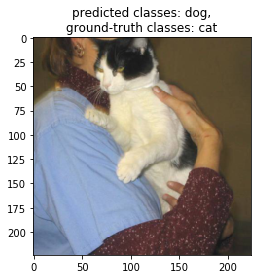

401


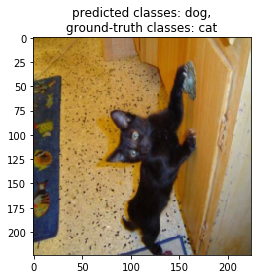

406


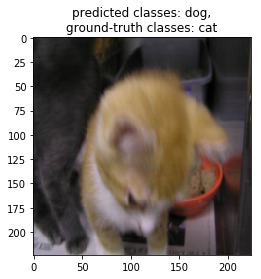

436


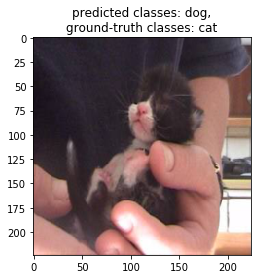

454


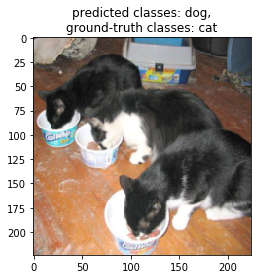

506


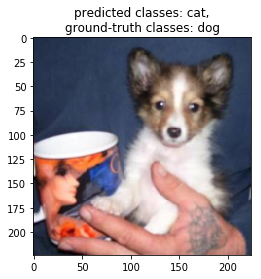

520


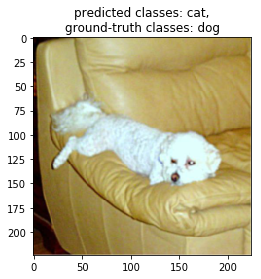

522


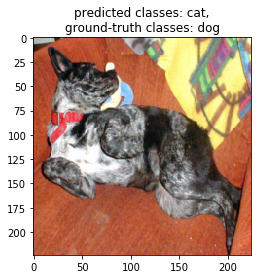

546


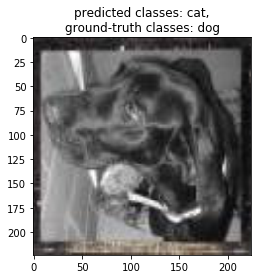

548


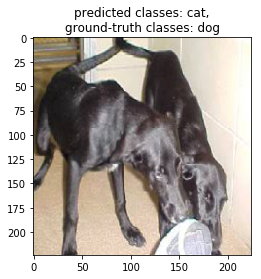

568


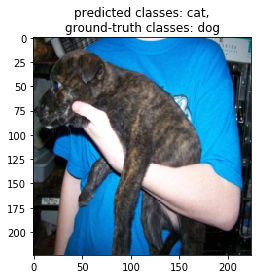

573


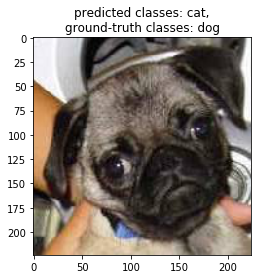

592


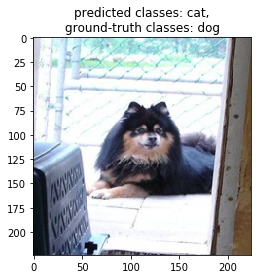

618


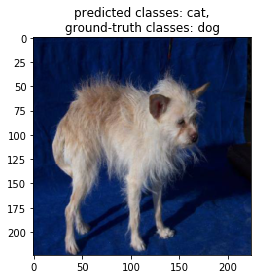

622


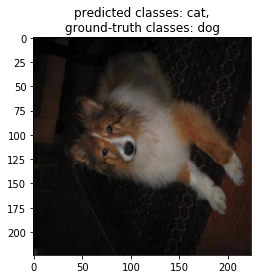

625


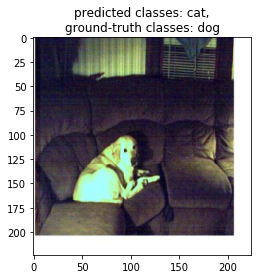

663


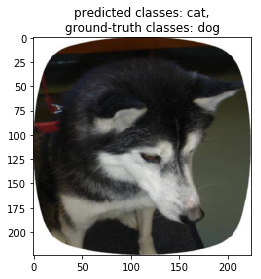

664


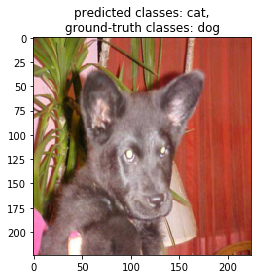

672


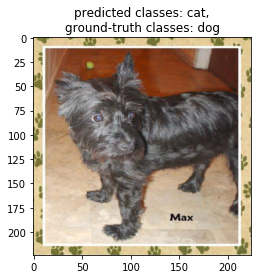

674


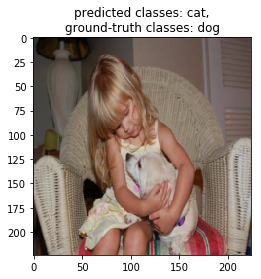

675


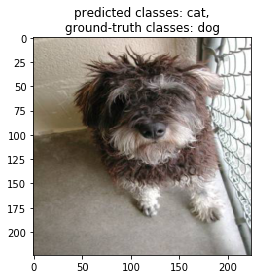

697


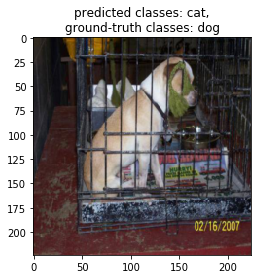

698


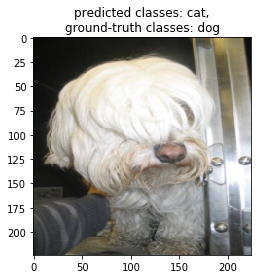

745


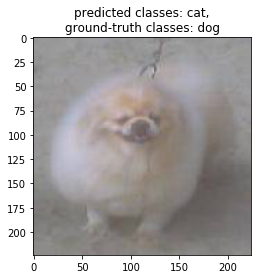

748


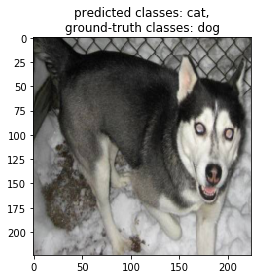

749


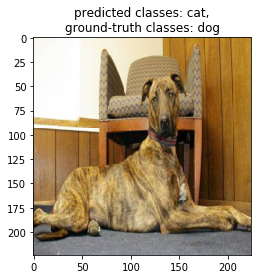

761


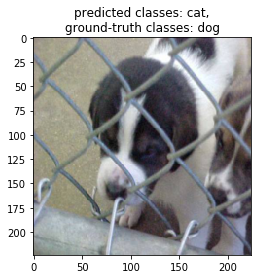

763


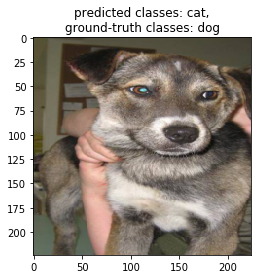

773


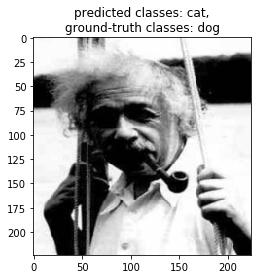

774


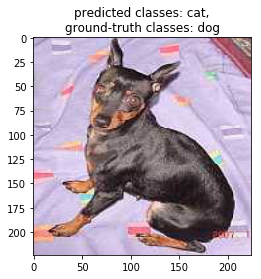

788


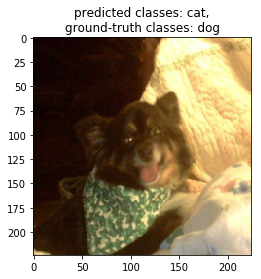

792


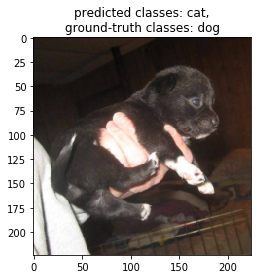

802


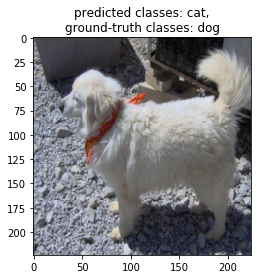

805


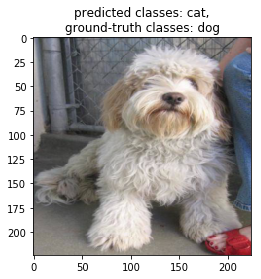

806


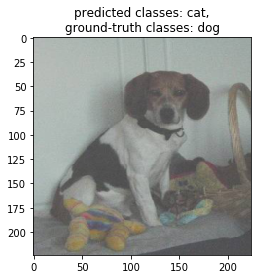

815


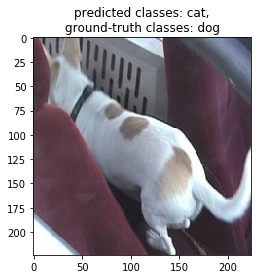

827


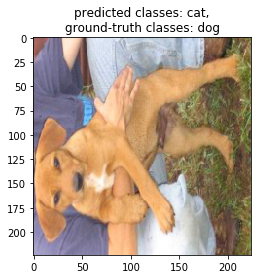

828


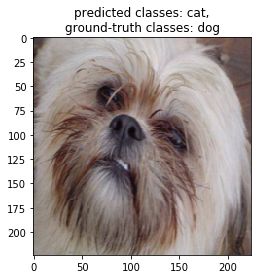

835


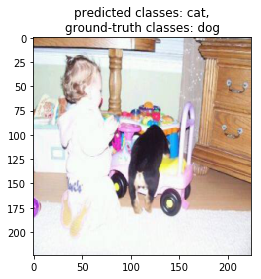

838


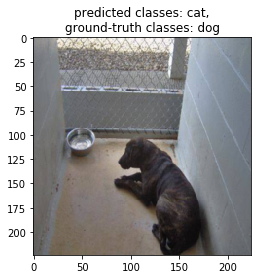

851


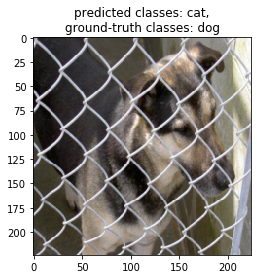

893


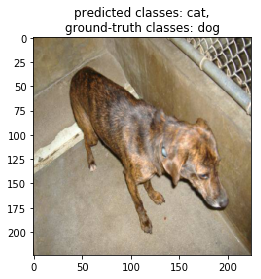

895


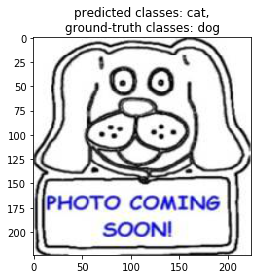

924


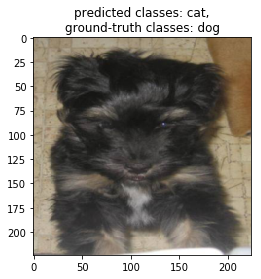

927


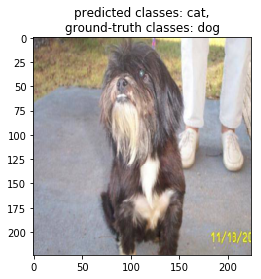

934


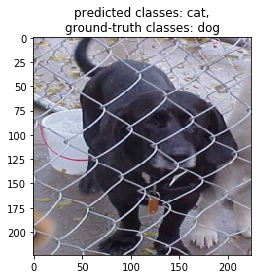

963


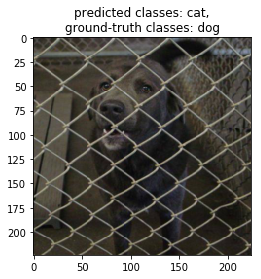

985


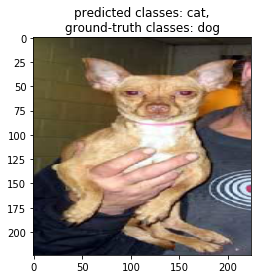

991


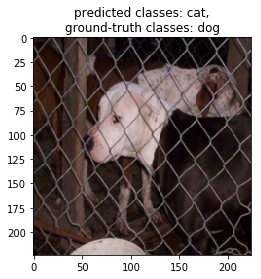

994


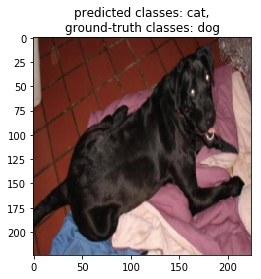

In [11]:
############################################ Visualization ###############################################
def visualize_false(model):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loaders['test']):
            inputs = data['image']
            labels_classes = data['classes'].to(device)

            x_classes = model(inputs.to(device))
            x_classes = x_classes.view( -1,2)
            _, preds_classes = torch.max(x_classes, 1)
            if preds_classes != labels_classes:
                print(i)
                plt.imshow(transforms.ToPILImage()(inputs.squeeze(0)))
                plt.title('predicted classes: {},\nground-truth classes: {}'.format(classes[preds_classes], 
                                                                                    classes[labels_classes], 
                                                                                    )
                         )
                plt.show()

visualize_false(model)

In [ ]:
def visualize_trainDataset(idx):
    '''
    训练数据可视化
    '''
    print(len(train_dataset))
    #提取第idx个数据
    sample = train_loader.dataset[idx]
    #sample['image'] ：tensor of image 
    print(idx, sample['image'].shape, classes[sample['classes']])
    img = sample['image']
    plt.imshow(transforms.ToPILImage()(img))
    plt.show()
visualize_trainDataset(754)